## Task e)  Image Retrieval on COCO with Faster R-CNN or Mask R-CNN

### Import required libraries

In [14]:
import glob
from itertools import chain
import os
import random
import zipfile
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models, ops
from typing import Any, Callable, List, Optional, Tuple
from PIL import Image
import json

### Dataset and data loader

In [15]:
PATH_TRAIN = "./COCO/train2014/"
PATH_VALID = "./COCO/val2014/"
ANNOTATIONS = "./COCO/mcv_image_retrieval_annotations.json"
from typing import Any, Callable, List, Optional, Tuple
import copy
from PIL import Image

class TripletData(datasets.VisionDataset):
    
    def __init__(self, root: str, annFile: str, annotationsTrain: str, transform: Optional[Callable] = None, target_transform: Optional[Callable] = None, transforms: Optional[Callable] = None, train=True) -> None:
        super().__init__(root, transforms, transform, target_transform)
        from pycocotools.coco import COCO
        self.data = None
        self.train = train
        if self.train == True:
            self.data = 'train'
        else:
            self.data = 'val'

        self.coco = COCO(annFile)
        self.ids = list(sorted(self.coco.imgs.keys()))

        self.image_categories = {}
        self.categories = []
        self.contents = None

         # load JSON data into a dictionary
        with open(annotationsTrain, 'r') as j:
            self.contents = json.loads(j.read())
        for category in self.contents[self.data]:
            self.categories.append(str(category))


        for category in self.contents[self.data]:
            for image_id in self.contents[self.data][str(category)]:
                if str(image_id) not in self.image_categories:
                    self.image_categories[str(image_id)] = []
                self.image_categories[str(image_id)].append(str(category))

        # get the keys of the dictionary
        keys = list(self.image_categories.keys())

        # create a dictionary that maps a number starting from 0 to a key
        self.mapped_keys = {i: key for i, key in enumerate(keys)}

    def _load_image(self, id: int) -> Image.Image:
        path = self.coco.loadImgs(id)[0]["file_name"]
        return path

    def _load_target(self, id: int) -> List[Any]:
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def _fix_target(self, target1: dict) -> dict:
        boxes = []
        labels = []

        for object in target1:
            boxes.append(object['bbox'])
            labels.append(object['category_id'])
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        boxes = torch.squeeze(boxes)
        boxes = ops.box_convert(boxes, 'xywh', 'xyxy')
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target_im1 = {}
        target_im1['boxes'] = boxes
        target_im1['labels'] = labels

        return target_im1
    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        index = self.mapped_keys[index]
        # pick a random object from the different objects inside the image
        category = random.choice(self.image_categories[str(index)])
        
        # choosing our pair of positive images (im1, im2)
        im1 = index
        im2 = random.choice(self.contents[self.data][str(category)])
        while im2 == im1:
            im2 = random.choice(self.contents[self.data][str(category)])
            
        # choosing a negative class and negative image (im3)
        negative_cats = copy.deepcopy(self.categories)
        for i in self.image_categories[str(im1)]:
            if i in negative_cats:
                negative_cats.remove(str(i))
                
        for i in self.image_categories[str(im2)]:
            if i in negative_cats:
                negative_cats.remove(str(i))
                
        negative_cat = str(random.choice(negative_cats))
        
        im3 = random.choice(self.contents[self.data][negative_cat])
        filename_im1, filename_im2, filename_im3  = self._load_image(int(im1)), self._load_image(int(im2)), self._load_image(int(im3))
        
        im1,im2,im3 = os.path.join(self.root, filename_im1), os.path.join(self.root, filename_im2), os.path.join(self.root, filename_im3)
        im1,im2,im3 = Image.open(im1).convert('RGB') , Image.open(im2).convert('RGB') , Image.open(im3).convert('RGB')
 

        if self.transform is not None:
            im1 = self.transform(im1)
            im2 = self.transform(im2)
            im3 = self.transform(im3)

        return (im1, im2, im3)


    def __len__(self) -> int: #FIX THIS SHIT
        return len(self.image_categories) - 1


# Transforms
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

def collate_fn(batch):
    #print(batch)
    return tuple(zip(*batch))



In [18]:
# Datasets and Dataloaders
train_data = TripletData(PATH_TRAIN,'./COCO/instances_train2014.json', annotationsTrain=ANNOTATIONS, transform=train_transforms)
val_data = TripletData(PATH_VALID, './COCO/instances_val2014.json', annotationsTrain=ANNOTATIONS, transform=val_transforms, train=False)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=32, shuffle=True, num_workers=0) # ''' collate_fn=collate_fn'''
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=32, shuffle=True, num_workers=0)

loading annotations into memory...
Done (t=11.23s)
creating index...
index created!
loading annotations into memory...
Done (t=6.14s)
creating index...
index created!


### Triplet loss and training pipeline

In [ ]:
class TripletLoss(nn.Module):
    def __init__(self, margin=0.5):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)
    
    # Distances in embedding space is calculated in euclidean
    def forward(self, anchor, positive, negative):
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()
      
epochs = 3
device = 'cuda'

# Our base model
#model = models.resnet18().cuda()
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True).backbone.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
triplet_loss = TripletLoss(margin=0.5)

# Training
for epoch in range(epochs):
    model.train()
  
    epoch_loss = 0.0
    index = 0
    for data in tqdm(train_loader):
        #print(data)
        optimizer.zero_grad()
       # print(data)
        x1,x2,x3 = data
        e1 = model(x1.to(device))
        e2 = model(x2.to(device))
        e3 = model(x3.to(device)) 
        loss = triplet_loss(e1["0"],e2["0"],e3["0"])
        index += 1
        epoch_loss += loss
        print("Batch Loss: {}".format(epoch_loss.item() / index))
        loss.backward()
        optimizer.step()
    print("Train Loss: {}".format(epoch_loss.item() / index))

    index = 0
    val_loss = 0.0
    with torch.no_grad():
        for data in tqdm(val_loader):
            print(data)
            x1,x2,x3 = data
            e1 = model(x1.to(device))
            e2 = model(x2.to(device))
            e3 = model(x3.to(device)) 
            loss = triplet_loss(e1["0"],e2["0"],e3["0"])
            index += 1
            val_loss += loss
    print("Val Loss: {}".format(val_loss.item() / index))
  




   

### Save model weights

In [20]:
torch.save(model.state_dict(), "weights-retrieval-0.5.pth")

### Load model weights

In [21]:
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True).backbone.cuda()
model.load_state_dict(torch.load('./weights.pth'))
device = "cuda"

In [22]:
import faiss 
FAISS_INDEX = faiss.IndexFlatL2()

### FAISS

In [23]:
#!pip install faiss-gpu
import faiss            
PATH_TRAIN = "./COCO/train2014/"
PATH_VALID = "./COCO/val2014/"
ANNOTATIONS = "./COCO/mcv_image_retrieval_annotations.json"
from pycocotools.coco import COCO


with open(ANNOTATIONS, 'r') as j:
            contents = json.loads(j.read())

coco = COCO('./COCO/instances_train2014.json')

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


 # Buiid Database
database_id = []
database = []
with torch.no_grad():

    for category in contents['database']:
            for image_id in contents['database'][str(category)]:
                   filename = coco.loadImgs(image_id)[0]["file_name"]
                   im = Image.open(os.path.join(PATH_TRAIN,filename)).convert('RGB')
                   im = im.resize((224,224))
                   im = torch.tensor(np.array([val_transforms(im).numpy()])).cuda()
                   output = model(im)
                   output = output["0"].detach().cpu().numpy().reshape(-1, np.prod(output["0"].size()[1:]))
                   #preds = np.array(np.array([preds['0'].cpu().numpy()]))
                   #print(output.shape)
                   database.append(output)
                   database_id.append(image_id)

database = np.asarray(database) 

database = database.reshape((database.shape[0], database.shape[1]*database.shape[2]))

index = faiss.IndexFlatL2(database.shape[1])
print("Adding database to index")
index.add(database)
print("Database added to index")

print("Buliding list of queries...")
#Build list of queries
queries = []
queries_id = []
coco_valid = COCO('./COCO/instances_val2014.json')
PATH_VALID = "./COCO/val2014/"
for category in contents['test']:
       for image_id in contents['test'][str(category)]:
              filename = coco_valid.loadImgs(image_id)[0]["file_name"]

              image = Image.open(os.path.join(PATH_VALID,filename)).convert('RGB')
              im = image.resize((224,224))
              im = torch.tensor(np.array([val_transforms(im).numpy()])).cuda()
              im = im.to(device)
              output = model(im)
              output = output["0"].detach().cpu().numpy().reshape(-1,np.prod(output["0"].size()[1:]))
              queries_id.append(image_id)
              queries.append(output)


queries = np.asarray(queries)
queries = queries.reshape((queries.shape[0], queries.shape[1]*queries.shape[2]))
#del database
print(queries.shape)
print("Searching K neighbors for each query")
D, I = index.search(queries, 5)
print("Finished searching")


loading annotations into memory...
Done (t=15.90s)
creating index...
index created!
Adding database to index
Database added to index
Buliding list of queries...
loading annotations into memory...
Done (t=80.54s)
creating index...
index created!
(2000, 802816)
Searching K neighbors for each query
Finished searching


### Compute precision

In [136]:

precision = []
for i in range(I.shape[0]):
    image_query_annotations = coco_valid.loadAnns(coco_valid.getAnnIds(queries_id[i]))
    category_image_query = []
    for object in image_query_annotations:
        category_image_query.append(object["category_id"])
    TP = 0
    retrieved = 0
    for j in range(I[i].shape[0]):
    # for j in range(1):
        image_database_annotations = coco.loadAnns(coco.getAnnIds(database_id[I[i][j]]))
        category_image_database = []
        for object in image_database_annotations:
            category_image_database.append(object["category_id"])
        
        for element in category_image_database:
            if element in category_image_query:
                TP += 1
                break
        
        retrieved += 1

    precision.append(TP / retrieved)

precision = np.asarray(precision)
precision = np.mean(precision)



In [137]:
print(precision)


0.5271


### Compute mean average precision

In [135]:
import sklearn

average_precision = []
retrieved = 0
for i in range(I.shape[0]):
    image_query_annotations = coco_valid.loadAnns(coco_valid.getAnnIds(queries_id[i]))
    category_image_query = []
    for object in image_query_annotations:
        category_image_query.append(object["category_id"])
    ap = 0
    TP = 0

    for j in range(I[i].shape[0]):
        image_database_annotations = coco.loadAnns(coco.getAnnIds(database_id[I[i][j]]))
        category_image_database = []
        for object in image_database_annotations:
            category_image_database.append(object["category_id"])
        
        for element in category_image_database:
            if element in category_image_query:
                TP += 1
                ap += TP / (j+1)
                break
    if TP == 0:
        average_precision.append(0)
    else:
        average_precision.append(ap/TP)  

print(np.asarray(average_precision).mean())


MAP = np.mean(average_precision)

0.6357055555555555


In [ ]:
import sklearn.metrics 


y_true = [1,0,1,0,1]
y_score = [1,0.8,0.6,0.4,0.2]
print(sklearn.metrics.average_precision_score(y_true, y_score))

average_precision = []
retrieved = 0
for i in range(I.shape[0]):
    image_query_annotations = coco_valid.loadAnns(coco_valid.getAnnIds(queries_id[i]))
    category_image_query = []
    for object in image_query_annotations:
        category_image_query.append(object["category_id"])
    ap = 0
    TP = 0
    y_true = []
    y_score = []
    for j in range(I[i].shape[0]):
        image_database_annotations = coco.loadAnns(coco.getAnnIds(database_id[I[i][j]]))
        category_image_database = []
        for object in image_database_annotations:
            category_image_database.append(object["category_id"])
        found = False
        for element in category_image_database:
            if element in category_image_query:
                TP += 1
                found = True
                break

        if found:
            y_true.append(1)
        else:
            y_true.append(0)
    
    for i in range(len(y_true)):
        y_score.append(1 - i*(1.0/len(y_true)))
    average_precision.append(sklearn.metrics.average_precision_score(y_true, y_score))

map = np.mean(np.asarray(average_precision))
print(map)

[1182 1506 1697  394  801]
['COCO_train2014_000000235925.jpg', 'COCO_train2014_000000387546.jpg', 'COCO_train2014_000000060054.jpg', 'COCO_train2014_000000299346.jpg', 'COCO_train2014_000000118076.jpg']
[' umbrella', ' kite', ' boat airplane', ' chair person umbrella kite', ' person dog kite']


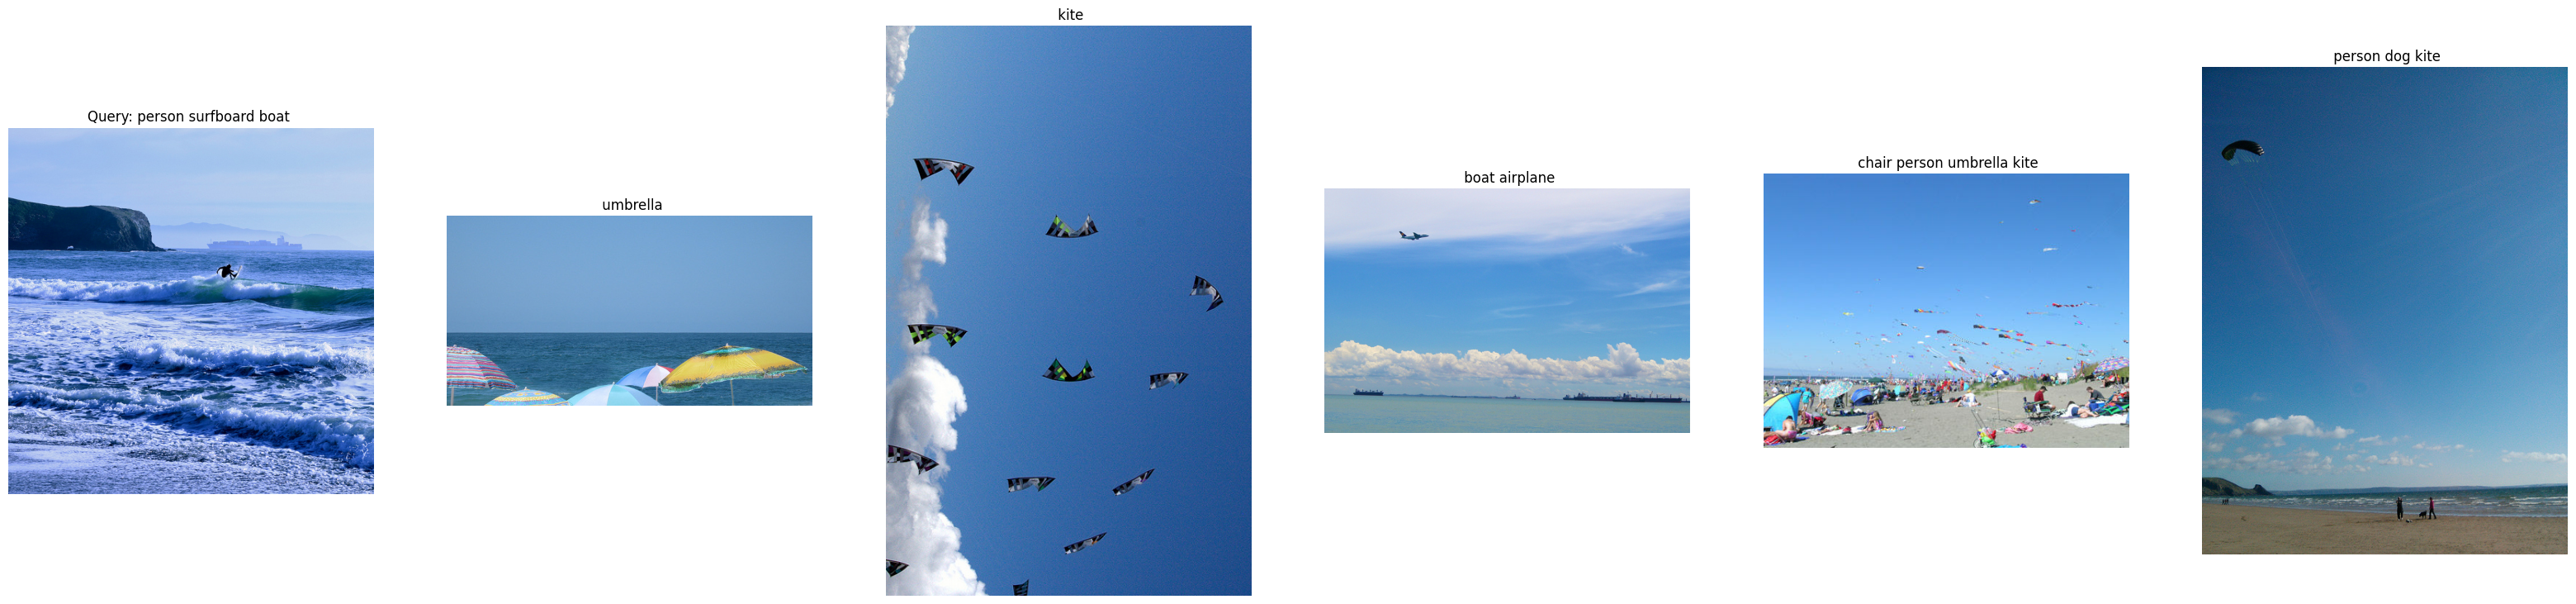

In [114]:
import matplotlib.pyplot as plt
import os

query_number = 8
print(I[0])
retrieved_images = []
retrieved_images_categories = []

classes =  ["", 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
           'fire hydrant', '', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep',
           'cow', 'elephant', 'bear', 'zebra', 'giraffe', '', 'backpack', 'umbrella', '', '', 'handbag', 'tie',
           'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
           'skateboard', 'surfboard', 'tennis racket', 'bottle', '', 'wine glass', 'cup', 'fork', 'knife', 'spoon',
           'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut',
           'cake', 'chair', 'couch', 'potted plant', 'bed', '', 'dining table', '', '', 'toilet', '', 'tv',
           'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink',
           'refrigerator', '', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
           'toothbrush']

for j in range(I[query_number].shape[0]):
        image_database_filename = coco.loadImgs(database_id[I[query_number][j]])[0]["file_name"]
        image_database_annotations = coco.loadAnns(coco.getAnnIds(database_id[I[query_number][j]]))
        image_category = []
        for object in image_database_annotations:
            image_category.append(object["category_id"])
        
        string = ""
        for i in set(image_category):
             string += " " 
             string +=classes[i]
             
        retrieved_images.append(image_database_filename)
        retrieved_images_categories.append(string)

print(retrieved_images)
print(retrieved_images_categories)

image_query_filename = coco_valid.loadImgs(queries_id[query_number])[0]["file_name"]
image_query_annotations = coco_valid.loadAnns(coco_valid.getAnnIds(queries_id[query_number]))
image_query_category = []
for object in image_query_annotations:
     image_query_category.append(object["category_id"])

string = "Query: "
for i in set(image_query_category):
     string += classes[i]
     string += " "
target_size = (200, 200)
# Set up the figure and subplots
fig, axes = plt.subplots(nrows=1, ncols=len(retrieved_images)+1, figsize=(40, 20))
img = plt.imread(os.path.join('./COCO/val2014/', image_query_filename))
axes[0].imshow(img)
axes[0].axis('off')
axes[0].set_title(string)
# Loop through each filename and plot the image
for i, filename in enumerate(retrieved_images):
    img = plt.imread(os.path.join('./COCO/train2014/',filename))
    # Resize the image
    axes[i+1].imshow(img)
    axes[i+1].axis('off')
    axes[i+1].set_title(retrieved_images_categories[i])

# Display the figure
plt.show()